<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/rotation_averaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* Build intuition for rotation averaging

# Resources
* Hartley, R., Trumpf, J., Dai, Y., & Li, H. (2013). Rotation Averaging. International Journal of Computer Vision, 103(3), 267–305. http://doi.org/10.1007/s11263-012-0601-0

#Setup

In [1]:
!pip install pytorch3d

     |████████████████████████████████| 30.0 MB 12.1 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 596 kB 61.5 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220212-py3-none-any.whl size=61216 sha256=69dbaaec83a6b6ab18c68959d64fa3e93a186531fea4fdd1bae59d884254fc0f
  Stored in directory: /root/.cache/pip/wheels/92/43/75/238d2a5d897274799f92b8938f3cd807a3ccd3c8f37c0a4725
Successfully built fvcore
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
import torch
from torch import tensor, distributions
from pytorch3d import transforms

# Random rotations

In [36]:
n_samples = 7
quat_rand = distributions.Uniform(tensor(0.).repeat(4*n_samples),tensor(1.).repeat(4*n_samples)).sample().reshape(n_samples,4)
quat_uni_rand = quat_rand / quat_rand.norm(dim=1).reshape(n_samples,1)
quat_uni_rand

tensor([[0.0908, 0.5379, 0.0885, 0.8334],
        [0.2070, 0.5750, 0.7223, 0.3236],
        [0.3976, 0.5882, 0.1856, 0.6793],
        [0.3628, 0.0251, 0.9308, 0.0378],
        [0.1036, 0.2079, 0.6837, 0.6919],
        [0.1626, 0.6206, 0.1824, 0.7451],
        [0.6255, 0.4318, 0.4838, 0.4339]])

In [41]:
rots = transforms.quaternion_to_matrix(quat_uni_rand)
rots.shape

torch.Size([7, 3, 3])

# Distances

## $\theta$: anglar / geodesic

* https://en.wikipedia.org/wiki/Logarithm_of_a_matrix
* https://www.cs.cmu.edu/~cga/dynopt/readings/Rmetric.pdf
* https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula

In [252]:
rot_ref = torch.eye(3)
q_ref = transforms.matrix_to_quaternion(rot_ref)

def comp_d_angle(S,Rs):
  SRt = torch.matmul(S.T,Rs)
  axis_angle = transforms.rotation_conversions.matrix_to_axis_angle(SRt)
  log_SRt = axis_angle
  d_angle = log_SRt.norm(p='fro',dim=1)
  return d_angle

d_angle = comp_d_angle(rot_ref,rots) 

$d_{chord}$

In [59]:
d_chord = (rot_ref - rots).norm(p='fro',dim=(1,2))

$d^2_{chord} = 2\sqrt2 \sin(\theta/2) \implies \theta = 2\arcsin [d^2_{chord} / (2\sqrt2)] $

In [253]:
theta = 2*torch.arcsin(d_chord/(2*2**.5))
torch.allclose(theta,d_angle)

True

Agrees with `comp_d_angle`

$d_{quat}$

In [225]:
d_quat_min = (q_ref - quat_uni_rand).norm(p='fro',dim=1)
d_quat_pl = (q_ref + quat_uni_rand).norm(p='fro',dim=1) # ((q_ref - quat_uni_rand[0])**2).sum()**.5

d_quat = torch.vstack([d_quat_min,d_quat_pl]).min(dim=0)[0]
d_quat

tensor([1.3485, 1.2594, 1.0976, 1.1289, 1.3390, 1.2941, 0.8655])

$d_{quat} = 2 \sin(\theta/4)$

In [226]:
two_sin_theta_4 = 2*torch.sin(theta/4)

In [227]:
import pandas as pd

df_dist = pd.DataFrame({'two_sin_theta_4':two_sin_theta_4,
              'd_quat':d_quat,
              'theta':theta,
              'd_chord':d_chord,
              'd_angle':d_angle
})



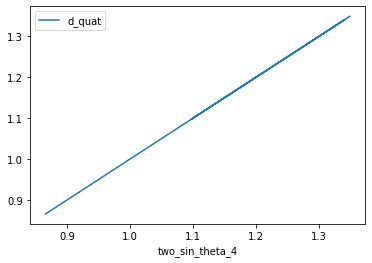

In [228]:
df_dist.plot(x='two_sin_theta_4',y='d_quat')

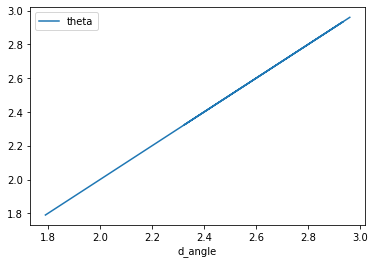

In [220]:
df_dist.plot(x='d_angle',y='theta')

# Algorithm 1
* 5.3 The Geodesic L2-Mean, Hartley et al
* Minimizes the L2 distance of the geodesic angle (ie squared sum of thetas between averaged rotation and each rotation to be averaged)

In [249]:
rot_av = rots[0]
eps = tensor(0.00001)

for _ in range(10):
  l2_d_angle = comp_d_angle(rot_av,rots).norm(p='fro')
  print('l2_d_angle {:.10f}'.format(l2_d_angle))
  RT_ri = torch.matmul(rot_av.T,rots)
  log_RT_Ri = transforms.rotation_conversions.matrix_to_axis_angle(RT_ri) 

  r = log_RT_Ri.mean(dim=0) # shape 3
  r_norm = r.norm()
  if r_norm < eps:
    print('finished')
    break
  else:
    print('not converged',r_norm)
    exp_r = transforms.axis_angle_to_matrix(r)
    rot_av = torch.matmul(rot_av,exp_r)


l2_d_angle 4.0087013245
not converged tensor(1.1078)
l2_d_angle 2.6973087788
not converged tensor(0.0289)
l2_d_angle 2.6961750984
not converged tensor(0.0015)
l2_d_angle 2.6961719990
not converged tensor(0.0001)
l2_d_angle 2.6961719990
finished
